In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
%matplotlib inline

In [151]:
from collections import namedtuple
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
    )
from river.stream import iter_sklearn_dataset
from river.expert import (
    Bandit,
    EpsilonGreedyRegressor,
    EpsilonGreedyClassifier,
    UCBBandit,
    UCBRegressor,
    UCBClassifier,
    Exp3Bandit,
    RandomBandit,
    RandomBanditRegressor,
    RandomBanditClassifier,
    OracleBandit
)

In [152]:
def make_xy_numpy(N=1000, p=1, intercept=0.0, seed=None, drift=False, noise_scale=1.0):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.normal(size=p, scale=2)

    x_arr = np.random.uniform(size=(N, p))
    noise = np.random.normal(size=N, scale=noise_scale)
    xb = intercept + np.sum(x_arr * beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
        
    y_arr = xb + noise

    return x_arr, y_arr, beta


Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])


def make_dataset(**kwargs):
    x_arr, y_arr, beta = make_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def make_stream(dataset=None, take=None):
    if dataset is None:
        dataset = make_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen


### Studying loss behavior

Paper on rewards scaling : 

    - [Learning values across many orders of magnitude](https://arxiv.org/pdf/1602.07714.pdf)
    
    - [Stack message](https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem)

### Defining pipeline and models

In [153]:
l2_val = [1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 2]
optimz = [optim.SGD]

def get_models(lr=0.35):
    grid = itertools.product(
        l2_val,
        [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler],
        optimz
    )
    
    return [generate_pipeline(l2=l2, lr=lr, scaler=scaler, optimizer=optimizer)
            for (l2, scaler, optimizer) in grid]

def generate_pipeline(lr=0.2, l2=0, scaler=None, optimizer=None):
    if scaler is None:
        scaler =  preprocessing.MinMaxScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    
    return pipeline

### Training and bandits

### Dataset generation

In [154]:
def record_loss(y):
    
    def bandit(**kwargs):
        band = EpsilonGreedyRegressor(**kwargs)
        
    y_pred = bandit.predict_one()

In [155]:
N = 2 * 1e4
p = 25
dataset = make_dataset(p=p, N=N, intercept=2, drift=False, noise_scale=.5)

In [156]:
take_N = 10000
use_oracle = False
use_provided_compute = False
save_percentages = "epsilon"

def compute_reward(y_pred, y_true, power=1):
    loss = np.power(np.abs(y_pred - y_true), power)
    return -loss#1 / (1 + np.sqrt(loss))
    #return 1 / (1 + np.sqrt(loss))

def gen_default_par():
    return dict(metric=metrics.MSE(), 
                reward_scaler=preprocessing.StandardScaler(),
                verbose=False,
                save_rewards=True)

bandits = {
#    "exp3"    : Exp3Bandit(models=get_models(), gamma=0.25, **gen_default_par()),
    "epsilon" : EpsilonGreedyRegressor(models=get_models(), epsilon=0.1, reduce_epsilon=None, **gen_default_par()),
    "ucb"     : UCBRegressor(models=get_models(), delta=.75, save_percentage_pulled=True, **gen_default_par()),
    "random"  : RandomBanditRegressor(models=get_models(), **gen_default_par()),
#    "random2"  : RandomBandit(models=get_models(), **gen_default_par()),
}


bandits_loss = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

bandits_rewards = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

bandits_regrets = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

for bandit in bandits.values():
    if use_provided_compute:
        bandit.compute_reward = compute_reward
    else:
        pass    

bandit_oracle = OracleBandit(models=get_models(), **gen_default_par())
if use_provided_compute:
    bandit_oracle.compute_reward = compute_reward

if save_percentages:
    bandits[save_percentages].save_percentage_pulled = True
    bandits[save_percentages].store_percentage_pulled = []
    
print_every = take_N // 4

gen = make_stream(dataset, take=take_N)
#gen = dataset_river.take(take_N)

for i, (x, y) in tqdm.tqdm(enumerate(gen)):
    if use_oracle:
        oracle_pred = bandit_oracle.predict_one(x, y)
        oracle_reward = compute_reward(oracle_pred, y)
        bandits_rewards["oracle"] += [oracle_reward]

    for bandit_label in bandits:
        y_pred = bandits[bandit_label].predict_one(x=x)
        bandit_reward = compute_reward(y_pred, y)
        if use_oracle:
            bandits_regrets[bandit_label] += [oracle_reward - bandit_reward]
        bandits_rewards[bandit_label] += [bandit_reward]
        #bandits_regrets[bandit_label] += [((y_pred - y) ** 2) -((oracle_pred - y) ** 2)]
        bandits_loss[bandit_label] += [(y_pred - y) ** 2]
        
        bandits[bandit_label].learn_one(x=x, y=y)
        if (i % print_every) == 0:
            print(bandit_label, ":", bandits[bandit_label].metric.get())
    
    if i == take_N // 2:
        new_models = list(np.random.choice(a=get_models(), size=10))
        pass#bandits["ucb"].add_models(new_models)
    
    if use_oracle:
        bandits_loss["oracle"] += [(oracle_pred - y) ** 2]
        bandit_oracle.learn_one(x=x, y=y)

#print(bandit.percentage_pulled)

0it [00:00, ?it/s]

epsilon : 0.30370207935560967
ucb : 0.30370207935560967
random : 0.30370207935560967


2623it [00:06, 447.47it/s]

epsilon : 1.318704549469874
ucb : 3.3178093584457895
random : 6.133490613820302


5125it [00:12, 461.02it/s]

epsilon : 1.2673387065430404
ucb : 2.0808932168405643
random : 5.221942865835003


7618it [00:17, 459.98it/s]

epsilon : 1.1721012330844267
ucb : 1.5875522331095733
random : 4.673772394881234


10000it [00:23, 432.22it/s]


# 3. Results analysis

In [157]:
FIGSIZE = (11, 7)

## 3.1. Percentages of times pulled (for a given bandit)

In [158]:
def prepared_percentage_df(percentage_pulled, threshold=0.5/100):
    times_pulled_df = pd.DataFrame(({i:pct for (i,pct) in enumerate(array)} for array in percentage_pulled))
    most_pulled = times_pulled_df.mean(axis=0)[lambda s: s >= threshold].index
    less_pulled = set(times_pulled_df.columns) - set(most_pulled)
    cleaned_pulled  = pd.concat([times_pulled_df.loc[:,list(most_pulled)],
                                 times_pulled_df[less_pulled].sum(axis=1).rename("other").to_frame()],
                                axis=1)
    return cleaned_pulled

In [159]:
cleaned_pulled  = prepared_percentage_df(bandits[save_percentages].store_percentage_pulled,
                                        threshold=0.25/100)

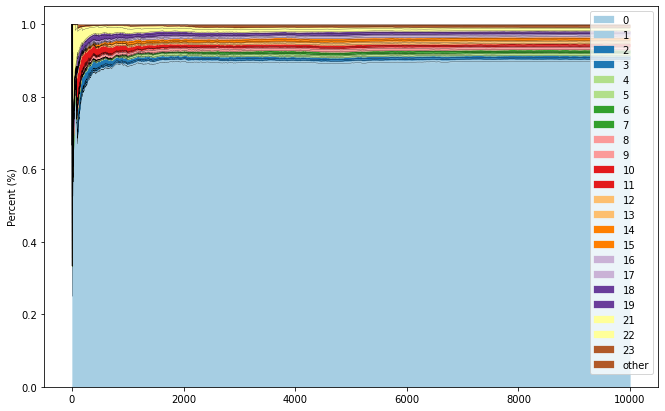

In [160]:
ax = cleaned_pulled.plot(kind="area", colormap="Paired", linewidth=.25, figsize=FIGSIZE)
ax.set_ylabel('Percent (%)')
[l.set_color("black") for l in ax.lines]
plt.show()

### 3.2. Comparing bandits loss (lower is better)

#### Rolling loss

The loss is defined as the squared difference between the target `y` and the prediction `y_pred` that is given by the method `predict_one`. Note that the `predict_one` method returns the prediction of the model with the highest average reward.

<AxesSubplot:>

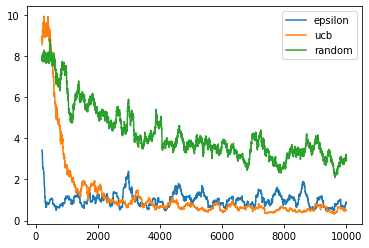

In [161]:
(pd.DataFrame({key:value[:] for key,value in bandits_loss.items() if len(value) > 0})
 .rolling(200)
 .mean()
 .iloc[:]
 .plot())

#### Cumulated sum of loss (lower is better)

<AxesSubplot:>

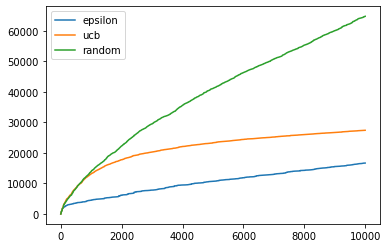

In [109]:
(pd.DataFrame({key:value for key, value in bandits_loss.items() if len(value) > 0})
 .cumsum()
 .plot())

### Inspecting oracle results

In [110]:
cumsum_oracle = np.array(bandit_oracle.rewards).cumsum(axis=0)
pd.Series(cumsum_oracle[-1,:]).plot(kind="bar")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Regret analysis

<AxesSubplot:>

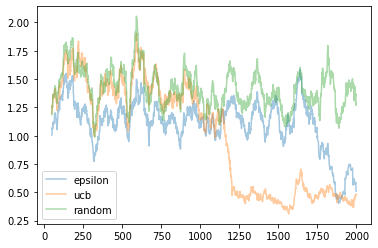

In [18]:
(pd.DataFrame({key:value for key,value in bandits_regrets.items() if len(value) > 0})
 .rolling(50)
 .mean()
 .plot(alpha=.4))

<AxesSubplot:>

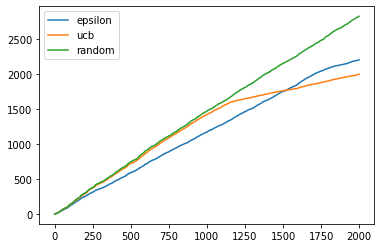

In [20]:
pd.DataFrame({key:value for key,value in bandits_regrets.items() if len(value) > 0}).cumsum().plot()

<AxesSubplot:>

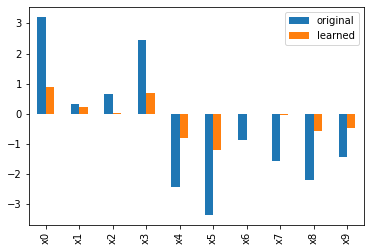

In [22]:
pd.DataFrame({"original": {feature_name:beta 
                           for (feature_name, beta) 
                           in zip(dataset.feature_names, dataset.beta)},
              "learned": bandits["ucb"].best_model["LinearRegression"].weights}).plot(kind="bar")